In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from sklearn.model_selection import train_test_split


import torch


if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")

import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt

# own utils
from utils.graph import *
from utils.tram_models import *
from utils.tram_model_helpers import *
from utils.tram_data import *
from utils.loss_continous import *
from utils.sampling_tram_data import *




Train with GPU support.


# 1. Experiments and Paths

In [2]:
experiment_name = "tramdag_paper_exp_6_2_mixed"   ## <--- set experiment name
seed=42
np.random.seed(seed)

LOG_DIR="/home/bule/TramDag/dev_experiment_logs"
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
DATA_PATH = EXPERIMENT_DIR # <----------- change to different source if needed
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")

os.makedirs(EXPERIMENT_DIR,exist_ok=True)
# check if configration dict already exists if not create:

if os.path.exists(CONF_DICT_PATH):
    configuration_dict=load_configuration_dict(CONF_DICT_PATH)
    print(f"Loaded existing configuration from {CONF_DICT_PATH}")
else:
    configuration_dict=create_and_write_new_configuration_dict(experiment_name,CONF_DICT_PATH,EXPERIMENT_DIR,DATA_PATH,LOG_DIR)
    print(f"Created new configuration file at {CONF_DICT_PATH}")

Loaded existing configuration from /home/bule/TramDag/dev_experiment_logs/tramdag_paper_exp_6_2_mixed/configuration.json


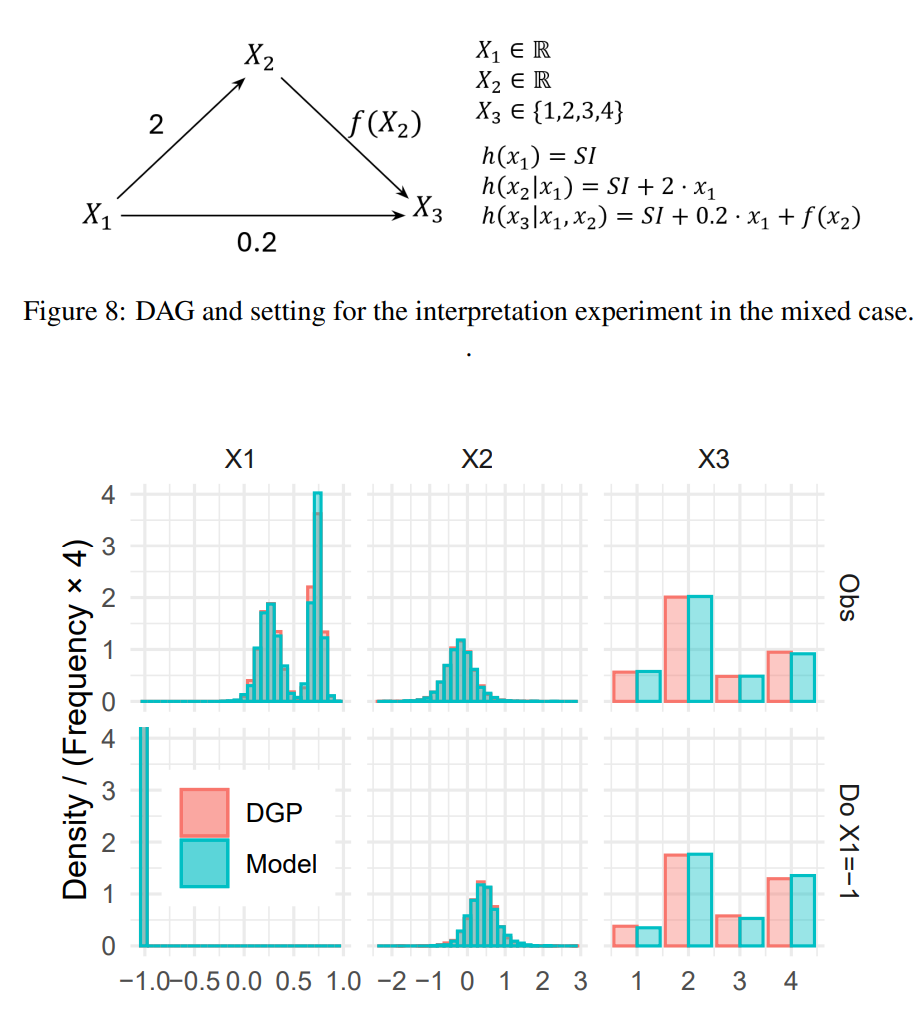

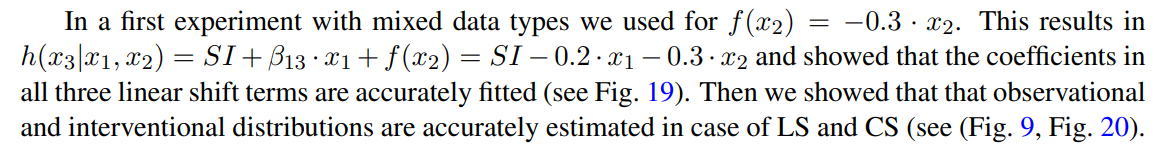

# 2.  Data

Setting seed: 42
         x1        x2 x3
0  0.299671 -0.274509  1
1  0.236174  0.463615  1
2  0.314769 -0.265411  1
3  0.699038  0.013699  1
4  0.226585 -0.117170  1
x3
0    11259
1    46382
2    13362
3    28997
Name: count, dtype: int64


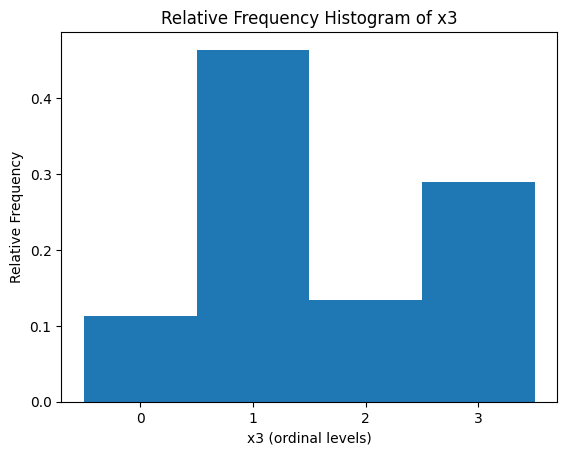

Loaded data from /home/bule/TramDag/dev_experiment_logs/tramdag_paper_exp_6_2_mixed/tramdag_paper_exp_6_2_mixed.csv
Configuration updated successfully.


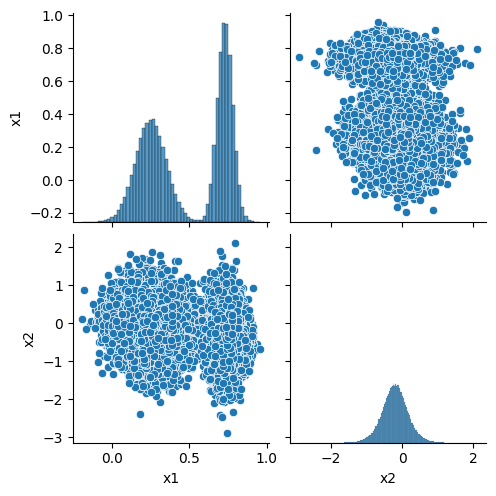

In [3]:


def dgp(n_obs, doX=[None, None, None], f=lambda x: x, seed=None):
    """
    Data-generating process matching the provided R implementation.
    
    Parameters
    ----------
    n_obs : int
        Number of observations to generate.
    doX : list of length 3
        If doX[i] is not None, fixes X_{i+1} to that constant for all draws.
    f : callable
        A function of X2 used in generating X3 (defaults to identity).
    seed : int or None
        If provided, sets the NumPy random seed.
    
    Returns
    -------
    pd.DataFrame
        DataFrame with columns ['x1', 'x2', 'x3'], where x3 is an ordered
        categorical with levels 1 < 2 < 3 < 4.
    """
    if seed is not None:
        np.random.seed(seed)
        print(f"Setting seed: {seed}")

    # --- 1. Sample X1 from a 2-component GMM ---
    if doX[0] is None:
        X1_A = np.random.normal(loc=0.25, scale=0.10, size=n_obs)
        X1_B = np.random.normal(loc=0.73, scale=0.05, size=n_obs)
        mix = np.random.choice([0, 1], size=n_obs)
        x1 = np.where(mix == 0, X1_A, X1_B)
    else:
        x1 = np.full(n_obs, doX[0], dtype=float)

    # --- 2. Sample X2 via shifted-logit inversion (as in R) ---
    if doX[1] is None:
        # draw U2 ~ Uniform(0,1) and map through quantile of logistic
        u2 = np.random.uniform(size=n_obs)
        z2 = np.log(u2 / (1 - u2))  # qlogis
        # replicate: X2 = (z2 - 2 * x1) / 5
        x2 = (z2 - 2 * x1) / 5.0
    else:
        x2 = np.full(n_obs, doX[1], dtype=float)

    # --- 3. Sample X3 as an ordinal via logistic thresholds ---
    if doX[2] is None:
        # latent U3 ~ Logistic(0,1)
        u3 = np.random.logistic(loc=0.0, scale=1.0, size=n_obs)
        # thresholds theta_k = (-2, 0.42, 1.02)
        theta = np.array([-2.0, 0.42, 1.02])
        # compute h[i,k] = theta_k + 0.2 * x1[i] + f(x2[i])
        h = theta + 0.2 * x1.reshape(-1, 1) + f(x2).reshape(-1, 1)
        # assign x3 starting at 0
        x3 = np.zeros(n_obs, dtype=int)
        x3[u3 > h[:, 0]] = 1
        x3[u3 > h[:, 1]] = 2
        x3[u3 > h[:, 2]] = 3
        # convert to ordered categorical
        x3 = pd.Categorical(x3, categories=[0, 1, 2, 3], ordered=True)
    else:
        x3 = pd.Categorical(
            np.full(n_obs, doX[2], dtype=int),
            categories=[0, 1, 2, 3],
            ordered=True
        )
    return pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3})



df = dgp(n_obs=100000, seed=42)
print(df.head())
print(df['x3'].value_counts().sort_index())

vals = df['x3'].astype(int)

# Define bin edges so each integer gets its own bar
bins = [-0.5, 0.5, 1.5, 2.5, 3.5]  # fits levels 0, 1, 2, 3
plt.hist(vals, bins=bins, density=True)
plt.xticks([0, 1, 2, 3])

plt.xlabel('x3 (ordinal levels)')
plt.ylabel('Relative Frequency')
plt.title('Relative Frequency Histogram of x3')
plt.show()

import seaborn as sns
sns.pairplot(df)

EXP_DATA_PATH=os.path.join(DATA_PATH, f"{experiment_name}.csv")
if not os.path.exists(EXP_DATA_PATH):
    df = dgp(n_obs=100000, seed=42)
    df['x3']=df['x3'].astype(int)
    print(df.head())
    df.to_csv(EXP_DATA_PATH, index=False)
else:
    df = pd.read_csv(EXP_DATA_PATH)
    df['x3']=df['x3'].astype(int)
    print(f"Loaded data from {EXP_DATA_PATH}")


data_type= {'x1':'continous','x2':'continous','x3':'ordinal_Xn_Yo'} # cont:continous, ord:ordinal, oher:everything else than images

write_data_type_to_configuration(data_type, CONF_DICT_PATH)



## 2.1 train test split

In [4]:
# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# 2. Compute quantiles from training data
quantiles = train_df.quantile([0.05, 0.95])
min_vals = quantiles.loc[0.05]
max_vals = quantiles.loc[0.95]

# 3. Normalize all sets using training quantiles
# def normalize_with_quantiles(df, min_vals, max_vals):
#     return (df - min_vals) / (max_vals - min_vals)

# train_df = normalize_with_quantiles(train_df, min_vals, max_vals)
# val_df = normalize_with_quantiles(val_df, min_vals, max_vals)
# test_df = normalize_with_quantiles(test_df, min_vals, max_vals)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 80000, Validation size: 10000, Test size: 10000


# 3. Define graph Structure

- define graph and which shift and intercept terms to use


/home/bule/TramDag/utils/graph.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


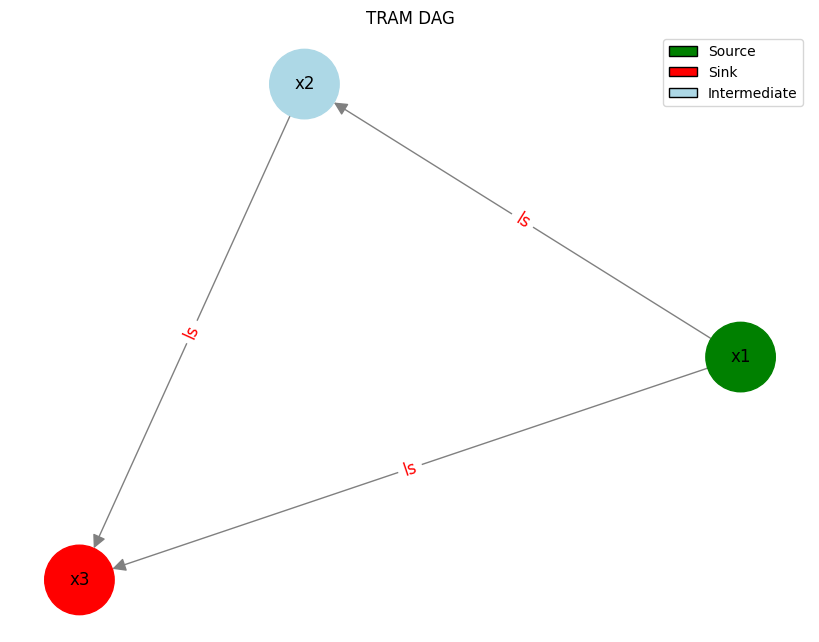

In [5]:
interactive_adj_matrix(CONF_DICT_PATH,seed=10)

# 4. Configuration for the Models

- all SI and LS model are generated outmatically since these are shallow NN's
- CI and CS have to be defined by the User and can be Passed for each model, -> generate default networks which are generated automaitcally

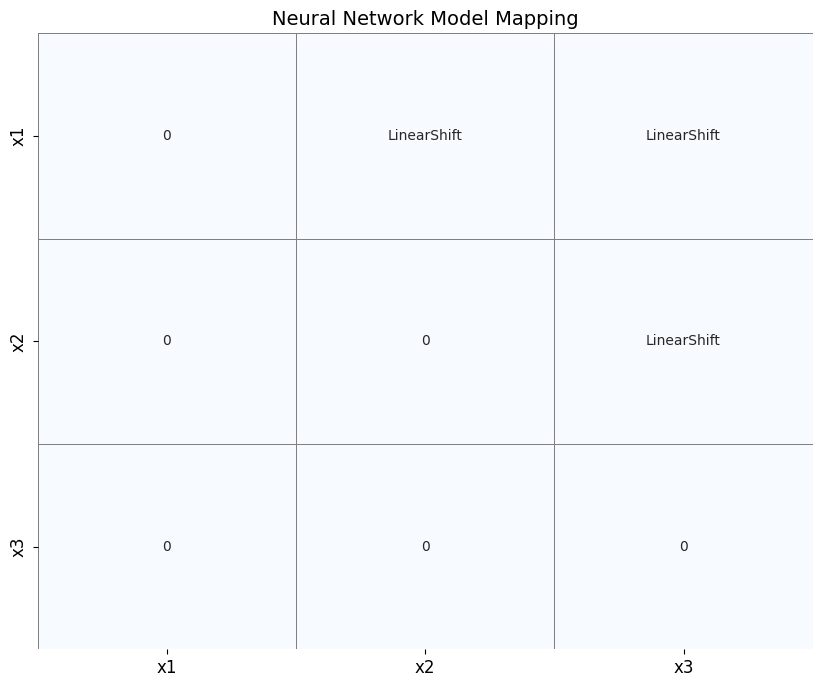

In [6]:
interactive_nn_names_matrix(CONF_DICT_PATH, seed=5)

In [7]:
levels_dict=create_levels_dict_v2(df,data_type)

write_nodes_information_to_configuration_v3(CONF_DICT_PATH, min_vals, max_vals,levels_dict)

{'x1': {'Modelnr': 0, 'data_type': 'continous', 'node_type': 'source', 'parents': [], 'parents_datatype': {}, 'transformation_terms_in_h()': {}, 'min': 0.12157964485414735, 'max': 0.794303998711493, 'transformation_term_nn_models_in_h()': {}}, 'x2': {'Modelnr': 1, 'data_type': 'continous', 'node_type': 'internal', 'parents': ['x1'], 'parents_datatype': {'x1': 'continous'}, 'transformation_terms_in_h()': {'x1': np.str_('ls')}, 'min': -0.8069206639187695, 'max': 0.418925659248077, 'transformation_term_nn_models_in_h()': {'x1': np.str_('LinearShift')}}, 'x3': {'Modelnr': 2, 'data_type': 'ordinal_Xn_Yo', 'levels': 4, 'node_type': 'sink', 'parents': ['x1', 'x2'], 'parents_datatype': {'x1': 'continous', 'x2': 'continous'}, 'transformation_terms_in_h()': {'x1': np.str_('ls'), 'x2': np.str_('ls')}, 'min': 0.0, 'max': 3.0, 'transformation_term_nn_models_in_h()': {'x1': np.str_('LinearShift'), 'x2': np.str_('LinearShift')}}}
Configuration updated successfully.


In [19]:
DEV_TRAINING=True
train_list=['x1','x2','x3']#['x2']#'x1','x2']#,'x3']#['x1']#['x1','x2','x3']#,#,['x1','x2','x3'] # <-  set the nodes which have to be trained , useful if further training is required else lsit all vars

batch_size = 512#4112
epochs = 700# <- if you want a higher numbe rof epochs, set the number higher and it loads the old model and starts from there
learning_rate=0.01
use_scheduler =  False

In [ ]:
# For each NODE 
configuration_dict = load_configuration_dict(CONF_DICT_PATH)
target_nodes = configuration_dict['nodes']
configuration_dict = load_configuration_dict(CONF_DICT_PATH)
target_nodes = configuration_dict['nodes']


for node in target_nodes:
    
    print(f'\n----*----------*-------------*--------------- Node: {node} ------------*-----------------*-------------------*--')
    ########################## 0. Skip nodes ###############################
    if node not in train_list:# Skip if node is not in train_list
        print(f"Skipping node {node} as it's not in the training list.")
        continue
    if (target_nodes[node]['node_type'] == 'source') and (target_nodes[node]['node_type'] == 'other'):# Skip unsupported types
        print(f"Node type : other , is not supported yet")
        continue

    ########################## 1. Setup Paths ###############################
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    os.makedirs(NODE_DIR, exist_ok=True)
    
    # Check if training is complete
    if not check_if_training_complete(node, NODE_DIR, epochs):
        continue
    
    
    ########################## 2. Create Model ##############################
    tram_model= get_fully_specified_tram_model_v5(node, target_nodes, verbose=True)

    
    ########################## 3. Create Dataloaders ########################
    train_loader, val_loader = get_dataloader_v5(node, target_nodes, train_df, val_df, batch_size=batch_size,return_intercept_shift=True, verbose=False)

    ########################## 5. Optimizer & Scheduler ######################.
    
    optimizer =torch.optim.Adam(tram_model.parameters(), lr=learning_rate)
    
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    else:
        scheduler = None

    ########################## 7. Training Loop ##############################
    
        train_val_loop_v5(
                   node,
                   target_nodes,
                   NODE_DIR,
                   tram_model,
                   train_loader,
                   val_loader,
                   epochs,
                   optimizer,
                   use_scheduler,
                   scheduler,
                   save_linear_shifts=False,
                   verbose=1,
                   device=device)



----*----------*-------------*--------------- Node: x1 ------------*-----------------*-------------------*--
Node x1 not trained yet or training incomplete. Starting from epoch 600.
Existing model found. Loading weights and history...


Epoch 601/700  Train Loss: -0.5747  Val Loss: -0.5788  [Train: 2.58s  Val: 0.44s  Total: 3.02s]
Epoch 602/700  Train Loss: -0.5754  Val Loss: -0.5788  [Train: 2.47s  Val: 0.42s  Total: 2.89s]
Epoch 603/700  Train Loss: -0.5746  Val Loss: -0.5788  [Train: 2.27s  Val: 0.40s  Total: 2.68s]
Epoch 604/700  Train Loss: -0.5751  Val Loss: -0.5788  [Train: 2.19s  Val: 0.41s  Total: 2.61s]
Epoch 605/700  Train Loss: -0.5748  Val Loss: -0.5787  [Train: 2.32s  Val: 0.38s  Total: 2.70s]
Epoch 606/700  Train Loss: -0.5752  Val Loss: -0.5787  [Train: 2.41s  Val: 0.43s  Total: 2.84s]
Epoch 607/700  Train Loss: -0.5743  Val Loss: -0.5788  [Train: 2.49s  Val: 0.42s  Total: 2.92s]
Epoch 608/700  Train Loss: -0.5747  Val Loss: -0.5788  [Train: 2.24s  Val: 0.41s  Total: 2.66s]
Epoch 609/700  Train Loss: -0.5747  Val Loss: -0.5787  [Train: 2.36s  Val: 0.39s  Total: 2.76s]
Epoch 610/700  Train Loss: -0.5749  Val Loss: -0.5788  [Train: 2.39s  Val: 0.39s  Total: 2.78s]
Epoch 611/700  Train Loss: -0.5752  Val 

# 6 Inspect Training

## 6.1 Loss vs epochs

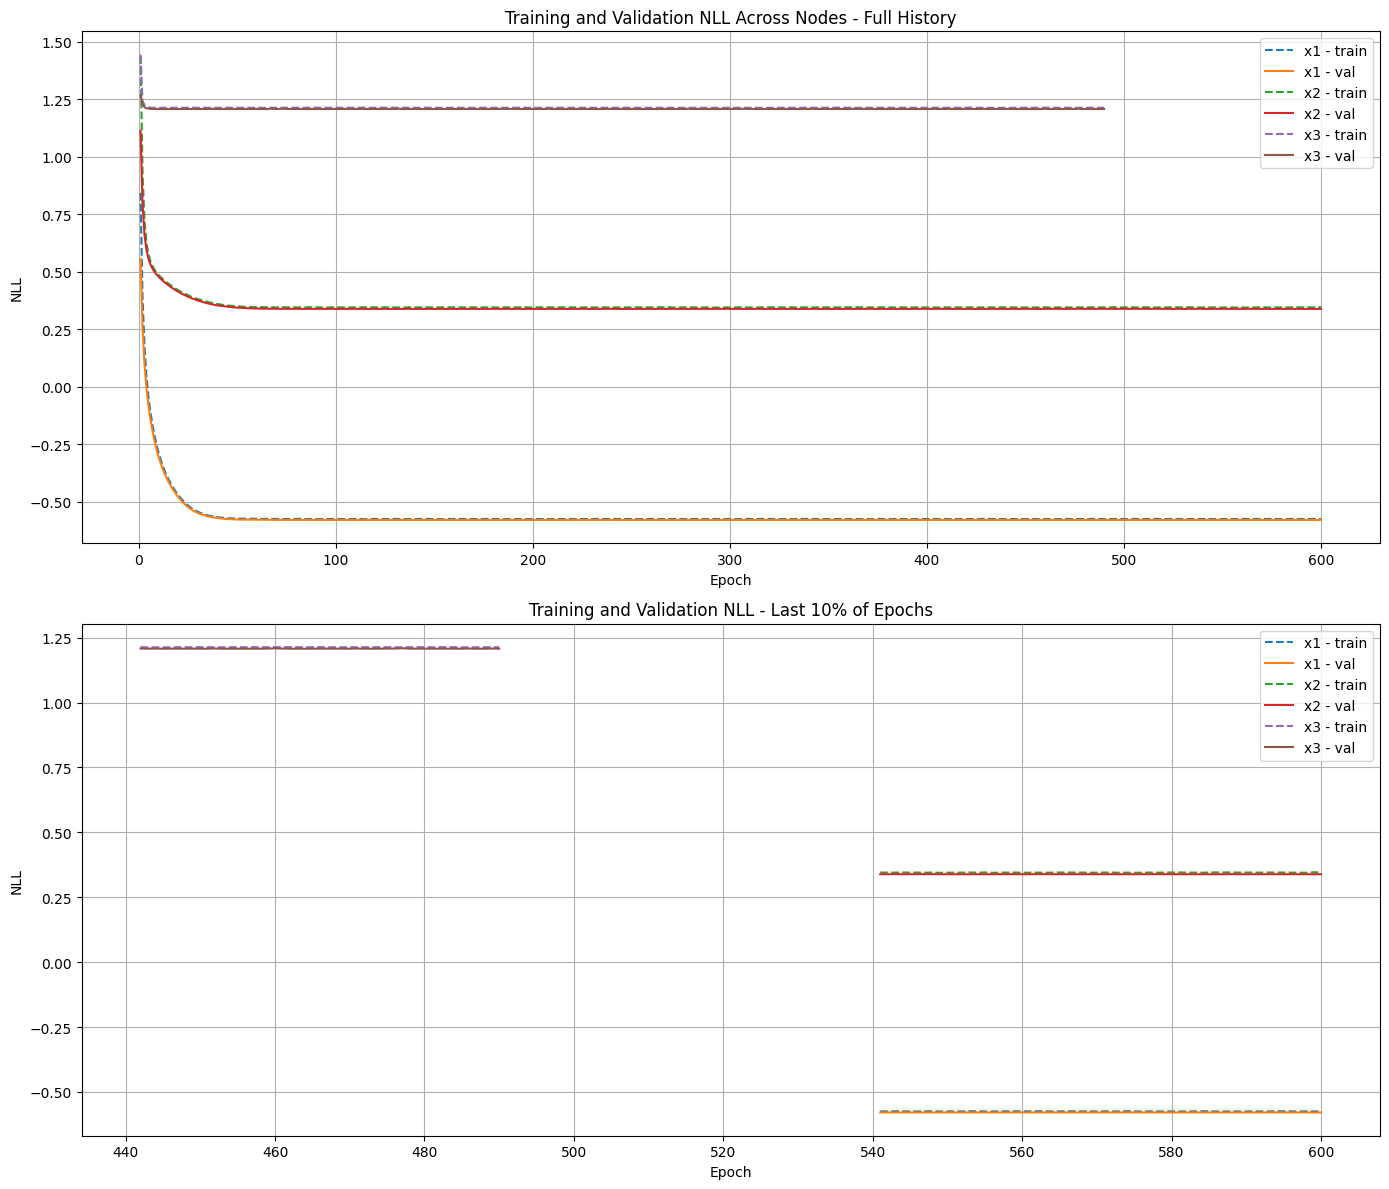

In [10]:
show_training_history(target_nodes,EXPERIMENT_DIR)

## 6.2 inspect transformation function for source nodes h()


----*----------*-------------*--------Inspect TRAFO Node: x1 ------------*-----------------*-------------------*--


h() for  x1:   0%|          | 0/1000 [00:00<?, ?it/s]


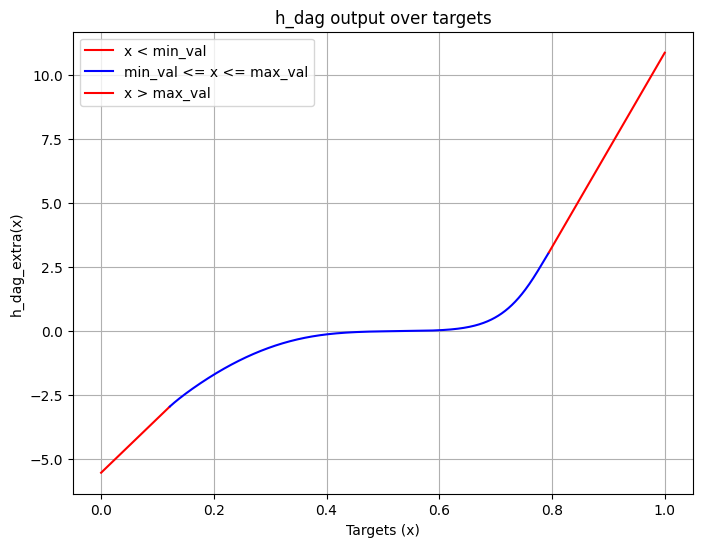


----*----------*-------------*--------Inspect TRAFO Node: x2 ------------*-----------------*-------------------*--
skipped.. since h does depend on parents and is different for every instance

----*----------*-------------*--------Inspect TRAFO Node: x3 ------------*-----------------*-------------------*--
skipped.. since h does depend on parents and is different for every instance


In [11]:
show_hdag_for_source_nodes_v3(target_nodes,EXPERIMENT_DIR,device,xmin_plot=0,xmax_plot=1)

----*----------*-------------*--------h(data) should be standard logistic: x1 ------------*-----------------*-------------------*--


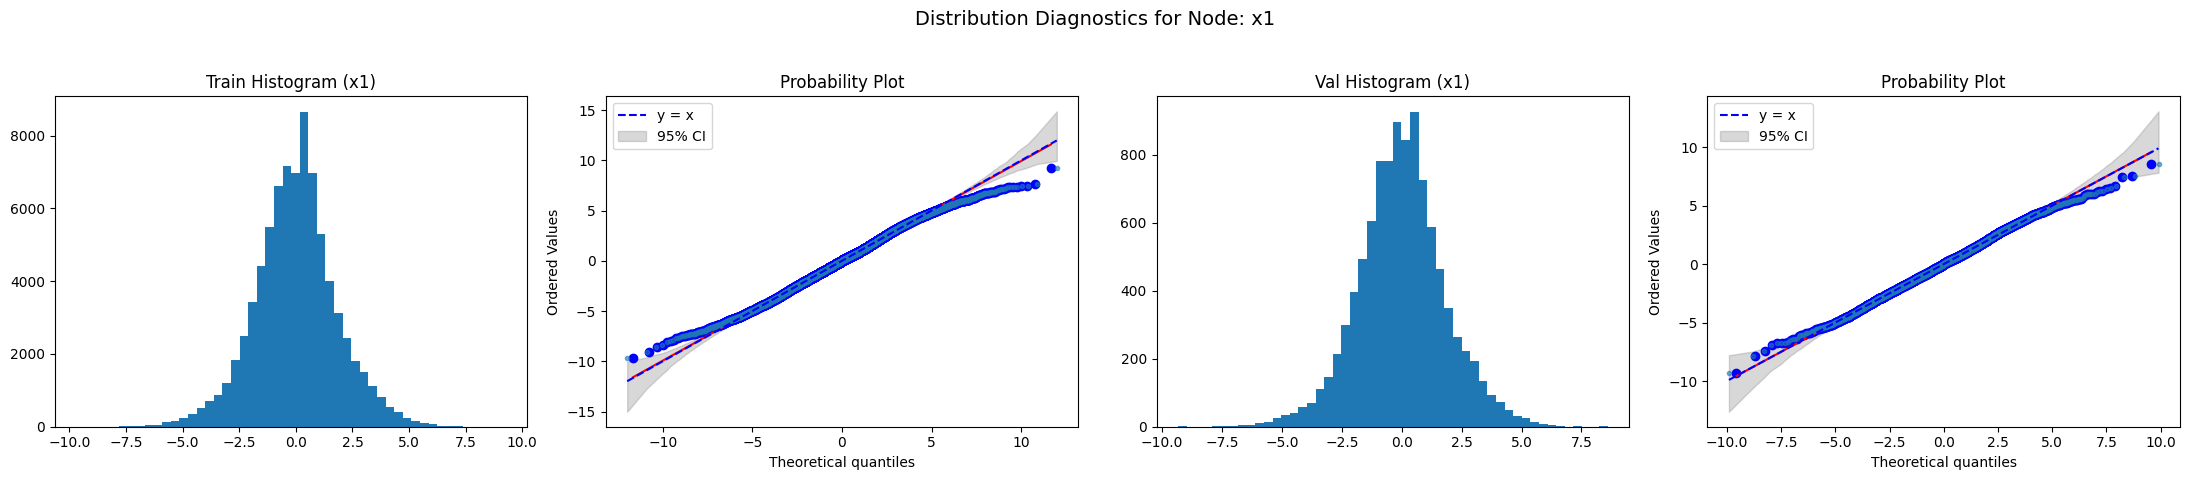

----*----------*-------------*--------h(data) should be standard logistic: x2 ------------*-----------------*-------------------*--


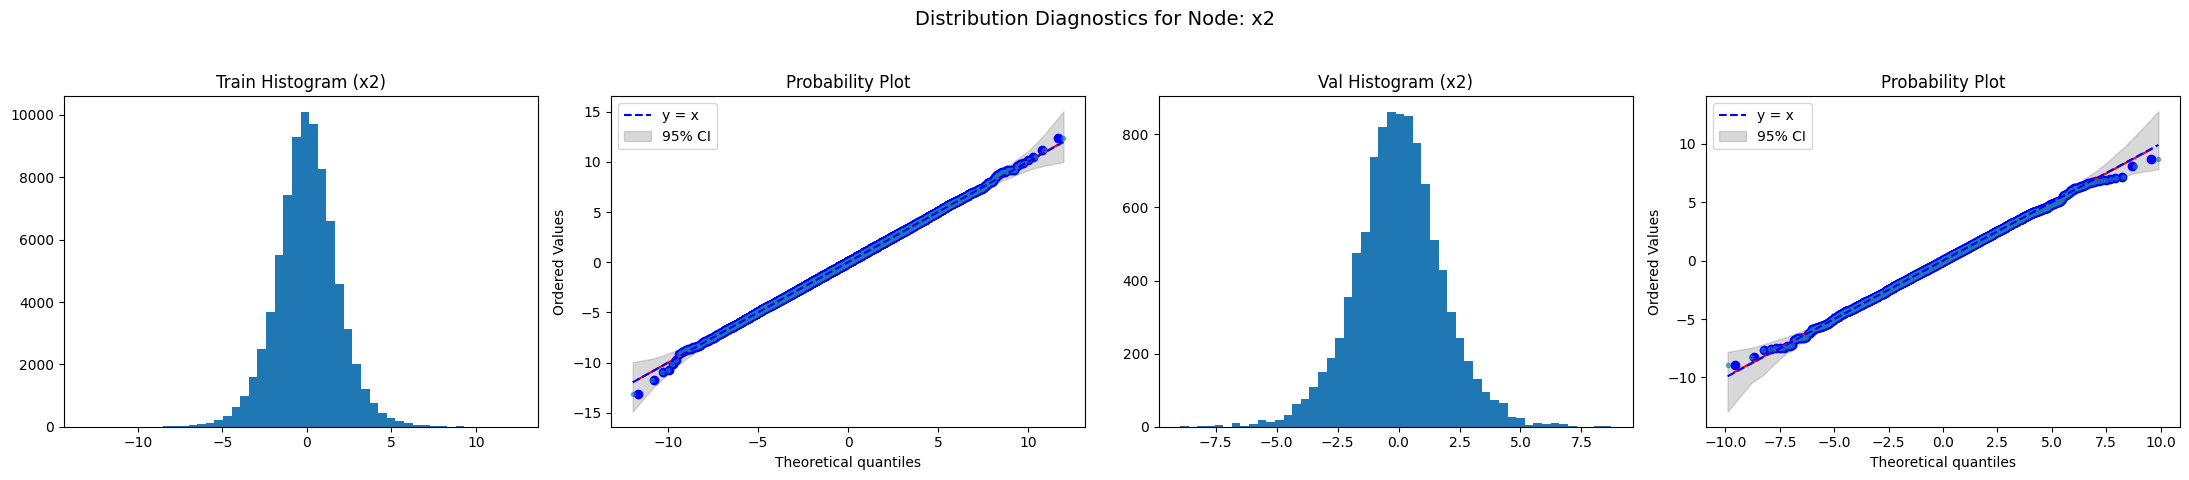

----*----------*-------------*--------h(data) should be standard logistic: x3 ------------*-----------------*-------------------*--
not defined for ordinal target variables


In [12]:
inspect_trafo_standart_logistic_v3(target_nodes, EXPERIMENT_DIR, train_df, val_df, device, verbose=False)

### Coefficient estimates

In [13]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # enable 3D plotting

# --- Your existing setup ---
verbose    = False
batch_size = 4112
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# this x is only for overlaying your target curve in 2D plots
x1d = torch.linspace(-1, 1, steps=1000).unsqueeze(1).to(device)  # (1000, 1)
def f(x):
    return 0.75 * np.arctan(5 * (x + 0.12))

for node in target_nodes:
    print(f"\n---- check LS of {node} ----")
    if target_nodes[node]['node_type'] == 'source':
        print("Node type: source — skipping.")
        continue

    # load your model
    NODE_DIR   = os.path.join(EXPERIMENT_DIR, node)
    model_path = os.path.join(NODE_DIR, "best_model.pt")
    tram_model = get_fully_specified_tram_model(node, target_nodes, verbose=verbose).to(device)
    tram_model.load_state_dict(torch.load(model_path))
    tram_model.eval()


    for i, module in enumerate(tram_model.nn_shift):
        name = module.__class__.__name__
        print(f"\nModule {i}: {name}")
        print(module)

        if name == 'LinearShift':
            print("  LinearShift weights:")
            print(module.fc.weight.data)
            continue

        # read wanted input dims
        in_feats = module.fc1.in_features
        print(f"  expects input shape = (batch_size, {in_feats})")

        # 2-input case → 3D surface plot
        if in_feats == 2:
            N = 100
            a = torch.linspace(-0, 2, steps=N, device=device)
            b = torch.linspace(-0, 2, steps=N, device=device)
            A, B = torch.meshgrid(a, b, indexing='ij')       # both (N, N)
            grid = torch.stack([A, B], dim=-1).view(-1, 2)   # (N*N, 2)

            with torch.no_grad():
                Y = module(grid).view(N, N).cpu().numpy()    # back to (N, N)

            A_np = A.cpu().numpy()
            B_np = B.cpu().numpy()

            fig = plt.figure()
            ax  = fig.add_subplot(111, projection='3d')
            ax.plot_surface(A_np, B_np, Y, cmap='viridis', edgecolor='none')
            ax.set_xlabel('input 1')
            ax.set_ylabel('input 2')
            ax.set_zlabel(f'{name}(x₁, x₂)')
            ax.set_title(f"{node} | Module {i}: {name} (3D surface)")
            plt.show()

        # 1-input case → 2D scatter
        else:
            N = 1000
            lin = torch.linspace(-1, 1, steps=N, device=device)
            dummy = lin.unsqueeze(1).repeat(1, in_feats)      # (N, in_feats)

            with torch.no_grad():
                y = module(dummy).squeeze().cpu().numpy()

            plt.figure()
            plt.scatter(dummy[:, 0].cpu().numpy(), y, s=5, label=f"{name} output")
            # overlay target
            plt.scatter(x1d.cpu().numpy(), -f(x1d.cpu().numpy()), c="red", s=5, label="target")
            plt.xlabel("input value")
            plt.ylabel("output value")
            plt.title(f"{node} | Module {i}: {name} (2D)")
            plt.legend()
            plt.show()



---- check LS of x1 ----
Node type: source — skipping.

---- check LS of x2 ----

Module 0: LinearShift
LinearShift(
  (fc): Linear(in_features=1, out_features=1, bias=False)
)
  LinearShift weights:
tensor([[1.9810]], device='cuda:0')

---- check LS of x3 ----


RuntimeError: Error(s) in loading state_dict for TramModel:
	size mismatch for nn_int.fc.weight: copying a param with shape torch.Size([3, 1]) from checkpoint, the shape in current model is torch.Size([20, 1]).

# 7. Sample from Graph

In [14]:
sample_full_dag_chandru_v2(target_nodes,
                            EXPERIMENT_DIR,
                            device,
                            do_interventions={},
                            number_of_samples= 10_000,
                            batch_size = 32,
                            delete_all_previously_sampled=False,
                            verbose=True,
                            debug=True)


----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[DEBUG] check_sampled_and_latents_v2: Found 'sampled.pt' in /home/bule/TramDag/dev_experiment_logs/tramdag_paper_exp_6_2_mixed/x1/sampling
[DEBUG] check_sampled_and_latents_v2: Found 'latents.pt' in /home/bule/TramDag/dev_experiment_logs/tramdag_paper_exp_6_2_mixed/x1/sampling

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[DEBUG] check_sampled_and_latents_v2: Found 'sampled.pt' in /home/bule/TramDag/dev_experiment_logs/tramdag_paper_exp_6_2_mixed/x2/sampling
[DEBUG] check_sampled_and_latents_v2: Found 'latents.pt' in /home/bule/TramDag/dev_experiment_logs/tramdag_paper_exp_6_2_mixed/x2/sampling

----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[DEBUG] check_sampled_and_latents_v2: Found 'sampled.pt' in /home/bule/TramDag/dev_experiment_logs/tramdag_paper_exp_

## 7.3 Inspect Sampling

In [15]:
def show_samples_vs_true_v3(
    df,
    target_nodes,
    experiment_dir,
    *,
    bins=100,
    hist_true_color="blue",
    hist_est_color="orange",
    figsize=(14, 5),
):
    for node in target_nodes:
        sample_path = os.path.join(experiment_dir, f"{node}/sampling/sampled.pt")
        if not os.path.isfile(sample_path):
            print(f"[WARNING] skip {node}: {sample_path} not found.")
            continue

        sampled = torch.load(sample_path).cpu().numpy()
        sampled = sampled[np.isfinite(sampled)]

        if node not in df.columns:
            print(f"[WARNING] skip {node}: column not found in DataFrame.")
            continue

        true_vals = df[node].dropna().values
        true_vals = true_vals[np.isfinite(true_vals)]

        if sampled.size == 0 or true_vals.size == 0:
            print(f"[WARNING] skip {node}: empty array after NaN/Inf removal.")
            continue

        fig, axs = plt.subplots(1, 2, figsize=figsize)

        if criteria_for_continous_modelled_outcome(node, target_nodes):
            # Continuous: histogram + QQ
            axs[0].hist(
                true_vals,
                bins=bins,
                density=True,
                alpha=0.6,
                color=hist_true_color,
                label=f"True {node}",
            )
            axs[0].hist(
                sampled,
                bins=bins,
                density=True,
                alpha=0.6,
                color=hist_est_color,
                label="Sampled",
            )
            axs[0].set_xlabel("Value")
            axs[0].set_ylabel("Density")
            axs[0].set_title(f"Histogram overlay for {node}")
            axs[0].legend()
            axs[0].grid(True, ls="--", alpha=0.4)

            qqplot_2samples(true_vals, sampled, line="45", ax=axs[1])
            axs[1].set_xlabel("True quantiles")
            axs[1].set_ylabel("Sampled quantiles")
            axs[1].set_title(f"QQ plot for {node}")
            axs[1].grid(True, ls="--", alpha=0.4)

        elif criteria_for_ordinal_modelled_outcome(node, target_nodes):
            # Ordinal: bar plot only
            unique_vals = np.union1d(np.unique(true_vals), np.unique(sampled))
            unique_vals = np.sort(unique_vals)

            true_counts = np.array([(true_vals == val).sum() for val in unique_vals])
            sampled_counts = np.array([(sampled == val).sum() for val in unique_vals])

            axs[0].bar(unique_vals - 0.2, true_counts / true_counts.sum(),
                       width=0.4, color=hist_true_color, alpha=0.7, label="True")
            axs[0].bar(unique_vals + 0.2, sampled_counts / sampled_counts.sum(),
                       width=0.4, color=hist_est_color, alpha=0.7, label="Sampled")

            axs[0].set_xticks(unique_vals)
            axs[0].set_xlabel("Ordinal Level")
            axs[0].set_ylabel("Relative Frequency")
            axs[0].set_title(f"Ordinal bar plot for {node}")
            axs[0].legend()
            axs[0].grid(True, ls="--", alpha=0.4)

            axs[1].axis("off")  # No QQ for ordinal

        else:
            # Fallback: assume categorical
            unique_vals = np.union1d(np.unique(true_vals), np.unique(sampled))
            unique_vals = sorted(unique_vals, key=str)

            true_counts = np.array([(true_vals == val).sum() for val in unique_vals])
            sampled_counts = np.array([(sampled == val).sum() for val in unique_vals])

            axs[0].bar(np.arange(len(unique_vals)) - 0.2, true_counts / true_counts.sum(),
                       width=0.4, color=hist_true_color, alpha=0.7, label="True")
            axs[0].bar(np.arange(len(unique_vals)) + 0.2, sampled_counts / sampled_counts.sum(),
                       width=0.4, color=hist_est_color, alpha=0.7, label="Sampled")

            axs[0].set_xticks(np.arange(len(unique_vals)))
            axs[0].set_xticklabels(unique_vals, rotation=45)
            axs[0].set_xlabel("Category")
            axs[0].set_ylabel("Relative Frequency")
            axs[0].set_title(f"Categorical bar plot for {node}")
            axs[0].legend()
            axs[0].grid(True, ls="--", alpha=0.4)

            axs[1].axis("off")

        plt.tight_layout()
        plt.show()

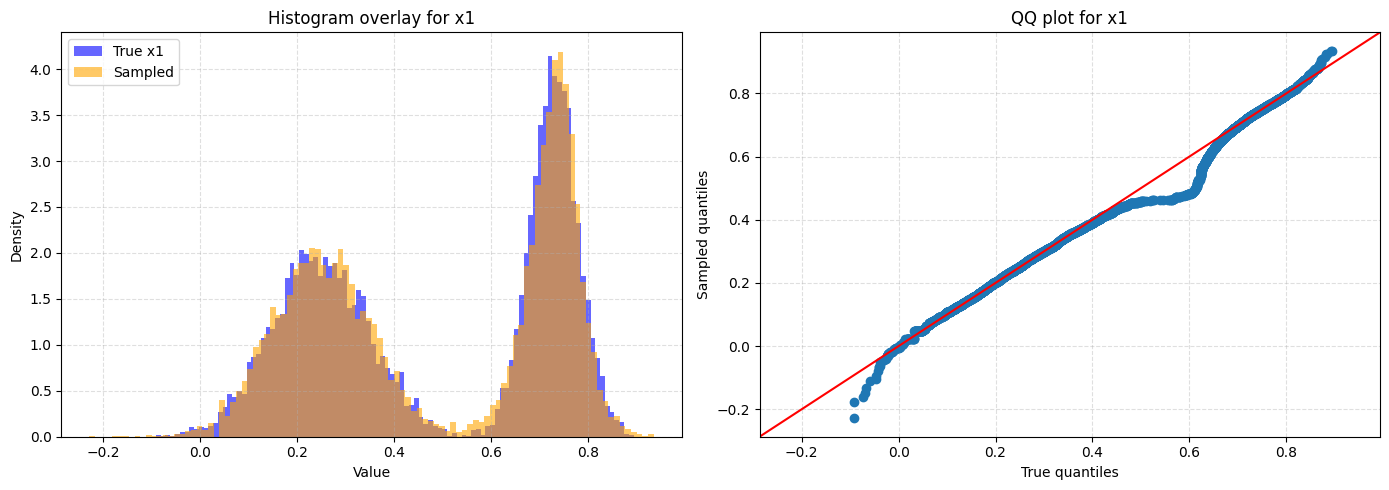

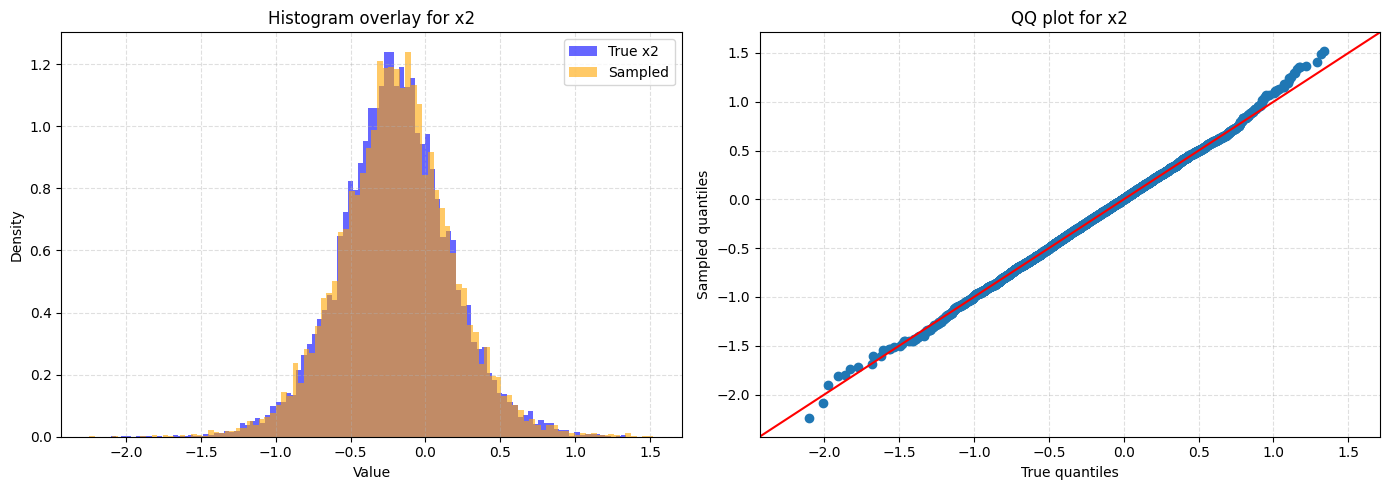

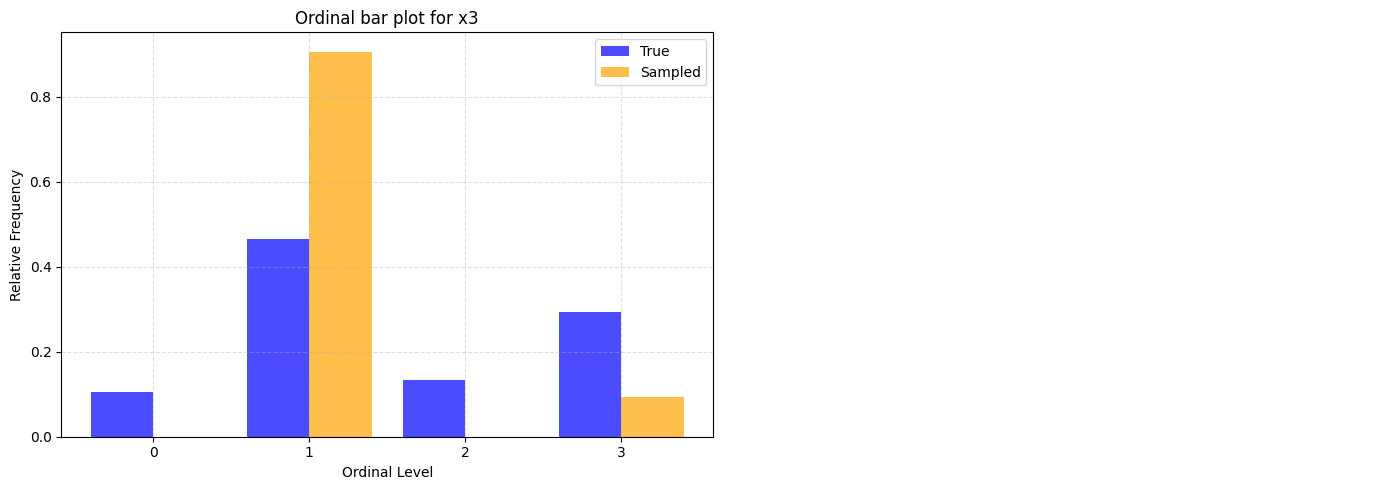

In [16]:
show_samples_vs_true_v3(test_df,target_nodes,EXPERIMENT_DIR)

## 7.4 Intervention

In [ ]:
def f(x):
    return -0.3*x  

intervention_df=dgp(10_000, doX=[-1.0, None, None], seed=-1)
sns.pairplot(intervention_df)
plt.suptitle("", y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
sample_full_dag_chandru(target_nodes,
                            EXPERIMENT_DIR,
                            device,
                            do_interventions={'x1':-1.0},
                            n= 10_000,
                            batch_size = 32,
                            delete_all_previously_sampled=True,
                            verbose=True)

In [ ]:
show_samples_vs_true(intervention_df,target_nodes,EXPERIMENT_DIR,rootfinder='chandrupatla')